# This entire notebook is the work of Alex Howe!

In [1]:
import pandas as pd
import numpy as np
from scapy.all import rdpcap
from collections import defaultdict
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, classification_report
from concurrent.futures import ProcessPoolExecutor
from sklearn.exceptions import NotFittedError


In [2]:
def load_attack_labels(label_file):
    df = pd.read_csv(label_file, sep=';', header=None, names=['packet_index', 'label'])
    return df['label'].values  # Only return the label column as an array
# Step 1: Parse the pcap file and extract packet timestamps and conversations
def parse_pcap(file):
    packets = rdpcap(file)
    conversations = defaultdict(list)
    packet_indices = defaultdict(list)  # To store global indices of packets in each conversation

    if len(packets) == 0:
        return conversations, packet_indices, len(packets)

    first_packet_time = float(packets[0].time)

    for i, packet in enumerate(packets):
        if packet.haslayer('Ethernet') and packet.haslayer('IP'):
            eth_src = packet.src
            eth_dst = packet.dst
            relative_timestamp = float(packet.time) - first_packet_time
            conversation = tuple(sorted([eth_src, eth_dst]))
            
            # Store relative timestamp and global index for each conversation
            conversations[conversation].append(relative_timestamp)
            packet_indices[conversation].append(i)  # Global packet index in the entire file

    return conversations, packet_indices, len(packets)  # Return total number of packets


In [3]:
def parse_pcap_v2(file):
    packets = rdpcap(file)
    conversations = defaultdict(list)
    packet_indices = defaultdict(list)  # To store global indices of packets in each conversation
    prev_packet_times = defaultdict(list)


    if len(packets) == 0:
        return conversations, packet_indices, len(packets)

    # first_packet_time = float(packets[0].time)

    for i, packet in enumerate(packets):
        if packet.haslayer('Ethernet') and packet.haslayer('IP'):
            eth_src = packet.src
            eth_dst = packet.dst            
            conversation = tuple(sorted([eth_src, eth_dst]))
            if conversation in prev_packet_times:
                relative_timestamp = float(packet.time) - prev_packet_times[conversation]
                conversations[conversation].append(relative_timestamp)
            prev_packet_times[conversation] = float(packet.time)
            # Store relative timestamp and global index for each conversation
            packet_indices[conversation].append(i)  # Global packet index in the entire file

    return conversations, packet_indices, len(packets)  # Return total number of packets

In [3]:
# Function to find optimal k for clustering using K-Means
def find_optimal_k(timestamps, max_k=10):
    timestamps = timestamps.reshape(-1, 1)
    best_k, best_score = 2, -1

    # Handle cases where timestamps have too few data points
    if len(timestamps) < 2:
        print(f"Not enough data points: {len(timestamps)} for KMeans clustering.")
        return None  # Return None to indicate no clustering is possible

    for k in range(2, min(max_k + 1, len(timestamps))):  # Ensure k does not exceed the number of data points
        try:
            kmeans = KMeans(n_clusters=k, random_state=42).fit(timestamps)

            # Check if KMeans successfully clustered more than one label
            if len(set(kmeans.labels_)) > 1:
                score = silhouette_score(timestamps, kmeans.labels_)
                if score > best_score:
                    best_score, best_k = score, k

        except ValueError as e:
            print(f"Error in KMeans with k={k}: {e}")

    return best_k if best_score != -1 else None  # Return None if no valid k is found


In [5]:
# Step 1: Parse normal data and train KMeans for each conversation
def process_conversation(normal_conversations, max_k=10):
    conversation_models = {}

    for conversation, timestamps in normal_conversations.items():
        timestamps = np.array(timestamps)

        # Determine optimal K for KMeans
        best_k = find_optimal_k(timestamps, max_k=max_k)

        if best_k:
            # print(f"Optimal k for conversation {conversation}: {best_k}")
            try:
                kmeans_model = KMeans(n_clusters=best_k, random_state=42).fit(timestamps.reshape(-1, 1))
                conversation_models[conversation] = kmeans_model  # Store the model for future use
            except ValueError as e:
                print(f"Error training KMeans for conversation {conversation}: {e}")
        else:
            print(f"Skipping conversation {conversation} due to insufficient data.")

    return conversation_models



In [3]:
#load up some files for visualization

normal_pcap_file = "data\\lemay\\Modbus_polling_only_6RTU.pcap"
attack_pcap_files = [
    "data\\lemay\\characterization_modbus_6RTU_with_operate.pcap",
    "data\\lemay\\CnC_uploading_exe_modbus_6RTU_with_operate.pcap",
    "data\\lemay\\exploit_ms08_netapi_modbus_6RTU_with_operate.pcap",
    "data\\lemay\\moving_two_files_modbus_6RTU.pcap",
    "data\\lemay\\send_a_fake_command_modbus_6RTU_with_operate.pcap"
]

# Corresponding label files
attack_labels = [
    "data\\lemay\\characterization_fixed.csv",
    "data\\lemay\\CnC_uploading_exe_modbus_6RTU_with_operate_labeled.csv",
    "data\\lemay\\exploit_fixed.csv",
    "data\\lemay\\moving_two_files_modbus_6RTU_labeled.csv",
    "data\\lemay\\sfc_fixed.csv"
]


In [24]:
import matplotlib.pyplot as plt
normals, normals_idx, _ = parse_pcap_v2(normal_pcap_file)
a = list(normals.keys())[0]
normal_1 = np.array(normals[a])

In [25]:
normals.keys()

dict_keys([('00:0c:29:58:97:2a', '00:0c:29:ee:b7:84'), ('00:0c:29:3c:11:3f', '00:0c:29:ee:b7:84'), ('00:0c:29:ee:b7:84', '00:0c:29:f9:a8:75'), ('00:0c:29:dc:42:e5', '00:0c:29:ee:b7:84'), ('00:0c:29:70:aa:b7', '00:0c:29:ee:b7:84'), ('00:0c:29:6e:ba:5e', '00:0c:29:ee:b7:84'), ('00:50:56:c0:00:08', 'ff:ff:ff:ff:ff:ff'), ('00:0c:29:ee:b7:84', 'ff:ff:ff:ff:ff:ff'), ('00:0c:29:f9:a8:75', 'ff:ff:ff:ff:ff:ff'), ('00:0c:29:6e:ba:5e', 'ff:ff:ff:ff:ff:ff'), ('00:50:56:c0:00:08', '01:00:5e:00:00:16'), ('00:50:56:c0:00:08', '01:00:5e:00:00:fc')])

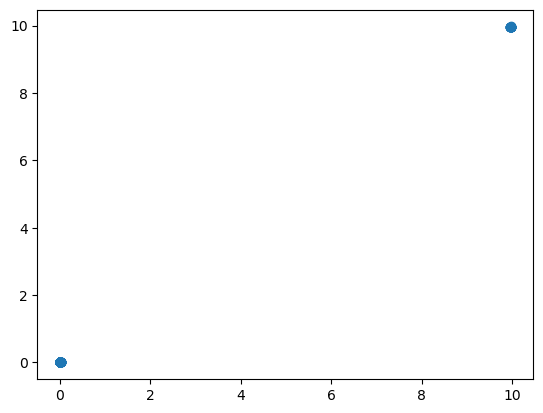

In [15]:
plt.scatter(normal_1, normal_1)

In [26]:
import random

In [28]:
random_timestamps = [random.randint(4,5) for i in range(0,100)]

In [16]:
sse = {}
for k in range(1,5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(normal_1.reshape(-1,1))
    #record sum of distances to centroids
    sse[k] = kmeans.inertia_


c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is

Text(0, 0.5, 'Avg Distance To Centroid')

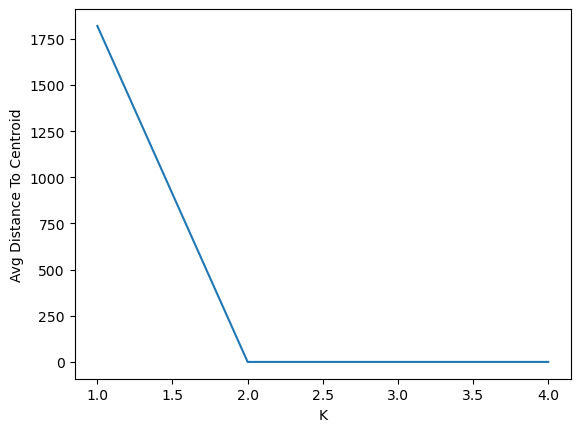

In [17]:
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("K")
plt.ylabel("Avg Distance To Centroid")

In [18]:
optimal_kmeans = KMeans(n_clusters=2, random_state=42).fit(normal_1.reshape(-1,1))


c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [19]:
vals = {0:[],1:[]}
data = normal_1.reshape(-1,1)
for i,l in enumerate(optimal_kmeans.labels_):
    vals[l].append(data[i][0])

In [20]:
avg_a = np.mean(vals[0])
std_a = np.std(vals[0])
print(f"Cluster 0 {avg_a} | Std Dev {std_a}")

Cluster 0 0.0012504747280707726 | Std Dev 0.002707587495656659


In [21]:
avg_a = np.mean(vals[1])
std_a = np.std(vals[1])
print(f"Cluster 1 {avg_a} | Std Dev {std_a}")

Cluster 1 9.96685578948573 | Std Dev 0.00412891898569916


In [89]:
from sklearn.metrics import silhouette_score

In [91]:
for k in range(2,6):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    clusters = kmeans.labels_
    sc = silhouette_score(data, clusters, metric="euclidean")
    print(f"k = {k} {sc}")


c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 2 0.9996996215927391


c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 3 0.9898802465056588


c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 4 0.9607803306978673


c:\Users\waffl\anaconda3\envs\funnygraph\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


k = 5 0.9548161243800738
